# Project: [Cleaning Bank Marketing Campaign Data](https://projects.datacamp.com/projects/1613)
## Project Description
Data cleaning is an important skill for data engineers, encompassing reading, modifying, splitting, and storing data. These abilities are highly sought after by businesses worldwide and continue to grow in demand.

In this notebook, you will apply your data-cleaning skills to process information about marketing campaigns run by a bank.

You will need to modify values, add new features, convert data types, and save data into multiple files.

![Piggy bank](piggy_bank.jpg)

Personal loans are a lucrative revenue stream for banks. The typical interest rate of a two-year loan in the United Kingdom is [around 10%](https://www.experian.com/blogs/ask-experian/whats-a-good-interest-rate-for-a-personal-loan/). This might not sound like a lot, but in September 2022 alone UK consumers borrowed [around £1.5 billion](https://www.ukfinance.org.uk/system/files/2022-12/Household%20Finance%20Review%202022%20Q3-%20Final.pdf), which would mean approximately £300 million in interest generated by banks over two years!

You have been asked to work with a bank to clean the data they collected as part of a recent marketing campaign, which aimed to get customers to take out a personal loan. They plan to conduct more marketing campaigns going forward so would like you to ensure it conforms to the specific structure and data types that they specify so that they can then use the cleaned data you provide to set up a PostgreSQL database, which will store this campaign's data and allow data from future campaigns to be easily imported. 

They have supplied you with a csv file called `"bank_marketing.csv"`, which you will need to clean, reformat, and split the data, saving three final csv files. Specifically, the three files should have the names and contents as outlined below:

**`client.csv`**

| column           | data type | description                                                | cleaning requirements                             |
|------------------|-----------|------------------------------------------------------------|---------------------------------------------------|
| `client_id`      | `integer` | Client ID                                                  | N/A                                               |
| `age`            | `integer` | Client's age in years                                      | N/A                                               |
| `job`            | `object`  | Client's type of job                                       | Change `"."` to `"_"`                             |
| `marital`        | `object`  | Client's marital status                                    | N/A                                               |
| `education`      | `object`  | Client's level of education                                | Change `"."` to `"_"` and `"unknown"` to `np.NaN` |
| `credit_default` | `bool`    | Whether the client's credit is in default                  | Convert to boolean data type                      |
| `mortgage`       | `bool`    | Whether the client has an existing mortgage (housing loan) | Convert to boolean data type                      |

<br>

**`campaign.csv`**
| column                       | data type  | description                                                       | cleaning requirements                                                                                                                                  |
|------------------------------|------------|-------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------|
| `client_id`                  | `integer`  | Client ID                                                         | N/A                                                                                                                                                    |
| `number_contacts`            | `integer`  | Number of contact attempts to the client in the current campaign  | N/A                                                                                                                                                    |
| `contact_duration`           | `integer`  | Last contact duration in seconds                                  | N/A                                                                                                                                                    |
| `previous_campaign_contacts` | `integer`  | Number of contact attempts to the client in the previous campaign | N/A                                                                                                                                                    |
| `previous_outcome`           | `bool`     | Outcome of the previous campaign                                  | Convert to boolean data type                                                                                                                           |
| `campaign_outcome`           | `bool`     | Outcome of the current campaign                                   | Convert to boolean data type                                                                                                                           |
| `last_contact_date`          | `datetime` | Last date the client was contacted                                | Create from a combination of `day`, `month`, and a newly created `year` column (which should have a value of `2022`); <br> **Format =** `"YYYY-MM-DD"` |

<br>

**`economics.csv`**

| column                 | data type | description                                                              | cleaning requirements |
|------------------------|-----------|--------------------------------------------------------------------------|-----------------------|
| `client_id`            | `integer` | Client ID                                                                | N/A                   |
| `cons_price_idx`       | `float`   | Consumer price index (monthly indicator)                                 | N/A                   |
| `euribor_three_months` | `float`   | Euro Interbank Offered Rate (euribor) three-month rate (daily indicator) | N/A                   |

### Examining our input data
Caveat - This notebook was using pandas version 2.1.3

In [35]:
import pandas as pd

# examine our input data
bank_marketing = pd.read_csv('data/bank_marketing.csv')
display(bank_marketing.head())
print(bank_marketing.info())

,client_id,age,job,marital,education,credit_default,mortgage,month,day,contact_duration,number_contacts,previous_campaign_contacts,previous_outcome,cons_price_idx,euribor_three_months,campaign_outcome
0,0,56,housemaid,married,basic.4y,no,no,may,13,261,1,0,nonexistent,93.994,4.857,no
1,1,57,services,married,high.school,unknown,no,may,19,149,1,0,nonexistent,93.994,4.857,no
2,2,37,services,married,high.school,no,yes,may,23,226,1,0,nonexistent,93.994,4.857,no
3,3,40,admin.,married,basic.6y,no,no,may,27,151,1,0,nonexistent,93.994,4.857,no
4,4,56,services,married,high.school,no,no,may,3,307,1,0,nonexistent,93.994,4.857,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   client_id                   41188 non-null  int64  
 1   age                         41188 non-null  int64  
 2   job                         41188 non-null  object 
 3   marital                     41188 non-null  object 
 4   education                   41188 non-null  object 
 5   credit_default              41188 non-null  object 
 6   mortgage                    41188 non-null  object 
 7   month                       41188 non-null  object 
 8   day                         41188 non-null  int64  
 9   contact_duration            41188 non-null  int64  
 10  number_contacts             41188 non-null  int64  
 11  previous_campaign_contacts  41188 non-null  int64  
 12  previous_outcome            41188 non-null  object 
 13  cons_price_idx              411

Based on our inspection input data we have no "missing" values but based on the information provided we know that missing values are actually listed as `unknown`. I could have used the `na_values=['unknown']` when creating the `bank_marketing` dataframe but I did this later. We can check how many times and in which columns the value `unknown` occurs.

In [36]:
# how many times and which columns contain the value unknown
(bank_marketing == 'unknown').sum()

client_id                        0
age                              0
job                            330
marital                         80
education                     1731
credit_default                8597
mortgage                       990
month                            0
day                              0
contact_duration                 0
number_contacts                  0
previous_campaign_contacts       0
previous_outcome                 0
cons_price_idx                   0
euribor_three_months             0
campaign_outcome                 0
dtype: int64

<Axes: title={'center': "Columns with the value 'unknown'"}, xlabel='count'>

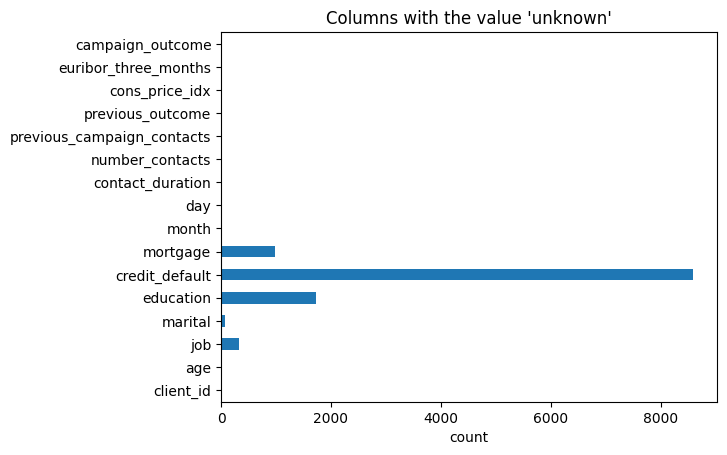

In [37]:
(bank_marketing == 'unknown').sum().plot(kind='barh', title='Columns with the value \'unknown\'', xlabel='count')

In [38]:
# checking the number of values of each category of education
bank_marketing.education.value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

`credit_default` and `mortgage` are expected to be boolean entries, let's validate.

In [39]:
bank_marketing['credit_default'].value_counts()

credit_default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

In [40]:
bank_marketing['mortgage'].value_counts()

mortgage
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

In [41]:
bank_marketing.query('mortgage == "unknown"')

,client_id,age,job,marital,education,credit_default,mortgage,month,day,contact_duration,number_contacts,previous_campaign_contacts,previous_outcome,cons_price_idx,euribor_three_months,campaign_outcome
29,29,55,unknown,married,university.degree,unknown,unknown,may,22,362,1,0,nonexistent,93.994,4.857,no
81,81,51,blue-collar,married,basic.4y,unknown,unknown,may,29,212,1,0,nonexistent,93.994,4.857,no
261,261,27,blue-collar,single,basic.6y,no,unknown,may,26,119,1,0,nonexistent,93.994,4.857,no
385,385,59,management,married,basic.4y,unknown,unknown,may,7,437,1,0,nonexistent,93.994,4.857,no
401,401,48,services,married,high.school,unknown,unknown,may,21,152,1,0,nonexistent,93.994,4.857,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40990,40990,31,admin.,single,university.degree,no,unknown,oct,7,192,1,1,success,94.601,1.008,yes
41014,41014,31,technician,single,professional.course,no,unknown,oct,25,212,2,0,nonexistent,94.601,1.025,yes
41015,41015,34,admin.,divorced,university.degree,no,unknown,oct,3,256,2,1,failure,94.601,1.025,no
41029,41029,46,management,married,university.degree,no,unknown,oct,10,83,2,2,failure,94.601,1.032,no


### A brief discussion on my approach
After completing my solution when I reviewed the approach/solution provided by DataCamp which was quite different. I had decided I was going to use the [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html#pandas-read-csv) function to generate the required dataframe for each file that we needed to output. While perhaps not the most efficient way I believe it may be more understandable and highlights some of the advanced features of the `read_csv` function. 

*A few minor things:* 
- CSV files don't retain data types. 
- np.NaN when saved out to a CSV file using [to_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html#pandas-dataframe-to-csv) will by default be empty.
- If this was a real-world situation I would ask for confirmation of the cleaning requirements
  - For `marital` - we observed that it contain `unknown` so would like to know if that should stay as is or removed. 
  - For `job` -  replacing the period with an underscore would result in `admin.` being converted to `admin_` and perhaps the period should be removed or ignored. 
  - For `education` - replacing period with an underscore may make sense but perhaps it should be a whitespace character instead. 

### Notes on Postgres and NULL values
From the PostgreSQL COPY CSV Format [documentation](https://www.postgresql.org/docs/15/sql-copy.html)
> The CSV format has no standard way to distinguish a NULL value from an empty string. PostgreSQL's COPY handles this by quoting. A NULL is output as the NULL parameter string and is not quoted, while a non-NULL value matching the NULL parameter string is quoted. For example, with the default settings, a NULL is written as an unquoted empty string, while an empty string data value is written with double quotes (""). Reading values follows similar rules. You can use FORCE_NOT_NULL to prevent NULL input comparisons for specific columns. You can also use FORCE_NULL to convert quoted null string data values to NULL.

From the PostgreSQL Boolean Type [documentation](https://www.postgresql.org/docs/15/datatype-boolean.html)
> The boolean type can have several states: “true”, “false”, and a third state, “unknown”, which is represented by the SQL null value.

From the PGadmin Import NULL Strings [documentation](https://www.pgadmin.org/docs/pgadmin4/latest/import_export_data.html#import-export-data-dialog)
> Specifies the string that represents a null value. The default is \N (backslash-N) in text format, and an unquoted empty string in CSV format. You might prefer an empty string even in text format for cases where you don’t want to distinguish nulls from empty strings. This option is not allowed when using binary format.

***
### Creating our client.csv data

**`client.csv`** expectations

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `age` | `integer` | Client's age in years | N/A |
| `job` | `object` | Client's type of job | Change `"."` to `"_"` |
| `marital` | `object` | Client's marital status | N/A |
| `education` | `object` | Client's level of education | Change `"."` to `"_"` and `"unknown"` to `np.NaN` |
| `credit_default` | `bool` | Whether the client's credit is in default | Convert to boolean data type |
| `mortgage` | `bool` | Whether the client has an existing mortgage (housing loan) | Convert to boolean data type |

Using the `read_csv` function we can use advanced parameters to get our desired results. 
1. We're only interested in the columns listed above so will specify them in list to the `usecols` parameter. 
2. We'll specify what values should be considered as `True` via the `true_value` parameter.
3. We'll specify what values should be consisderes as `False` via the `false_value` parameter. 
4. We'll specify what additional values (`unknown`) beside the defaults that should be treated as NaN via the `na_values` parameter . 
5. Because the `credit_default` and `mortgage` fields contain the string `unknown` pandas will set the data type on these columns to `object` when creating the dataframe with no dtypes specified.

In [31]:
client = pd.read_csv('data/bank_marketing.csv',
                     usecols=['client_id', 'age', 'job', 'marital', 'education', 'credit_default', 'mortgage'],
                     true_values=['yes'],
                     false_values=['no'],
                     na_values=['unknown']
                    )
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   client_id       41188 non-null  int64 
 1   age             41188 non-null  int64 
 2   job             40858 non-null  object
 3   marital         41108 non-null  object
 4   education       39457 non-null  object
 5   credit_default  32591 non-null  object
 6   mortgage        40198 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.2+ MB


Inspecting our `credit_default` and `mortgage` records.

In [32]:
client.credit_default.value_counts(dropna=False)

credit_default
False    32588
NaN       8597
True         3
Name: count, dtype: int64

In [33]:
client.mortgage.value_counts(dropna=False)

mortgage
True     21576
False    18622
NaN        990
Name: count, dtype: int64

Applying our string replacments on `education` and `job`

In [21]:
#apply string replacements
client['education'] = client['education'].str.replace('.', '_')
client['job'] = client['job'].str.replace('.', '')

In [22]:
client.education.unique()

array(['basic_4y', 'high_school', 'basic_6y', 'basic_9y',
       'professional_course', nan, 'university_degree', 'illiterate'],
      dtype=object)

### Converting values to boolean
In the project they didn't ask the user to convert the *NULL* values set on the `credit_default` and `mortgage` columns before converting to a boolean. 

In the solution 
```python
# Convert columns to bool data type
for col in ["credit_default", "mortgage"]:
    client[col] = client[col].astype(bool)
```
this would have resulted in the missing (np.NaN) values all being set to `True` due to how `.astype(bool)` treats `np.NaN` values. 

This would have resulted in clients with missing data under the `credit_default` column to be considered in **default** and clients with missing values under the `mortgage` columns would now have an **existing** mortgage. YIKES!

An example of what happens if you convert the column type to boolean without filling the missing values first.   

Our count of the mortgage values before converting to a boolean data:

**mortgage**

| value | count |
|-------|-------|
| True  | 21576 |
| False | 18622 |
| NaN   | 990   |

In [23]:
# create a copy of our data series so we don't mess up our current data
test = pd.Series()

# create a copy so we don't mangle the original column
test['mortgage'] = client['mortgage'].copy()

# display our current counts
display(test.mortgage.value_counts(dropna=False))

# convert the column to a boolean
test['mortgage'] = test['mortgage'].astype(bool)

# display our new counts
display(test.mortgage.value_counts(dropna=False))


mortgage
True     21576
False    18622
NaN        990
Name: count, dtype: int64

mortgage
True     22566
False    18622
Name: count, dtype: int64

As we can see above all of our missing values were converted to `True`. Which could be pretty bad. 

In [24]:
# confirm that we didn't overwrite the original data
client.mortgage.value_counts(dropna=False)

mortgage
True     21576
False    18622
NaN        990
Name: count, dtype: int64

Now let's convert it the way I believe it should've been done for this fictional exercise by first filling the missing values with `False` and then converting the column to a boolean.

In [25]:
# convert the data type to bool but set the np.NaN to False instead of True which is the default conversion
client['mortgage'] = client['mortgage'].fillna(False).astype(bool)
client['credit_default'] = client['credit_default'].fillna(False).astype(bool)

# print out the results of changes
client.mortgage.value_counts(dropna=False)

mortgage
True     21576
False    19612
Name: count, dtype: int64

We see that the `False` counts has increased and as a result I've chosen to indicate that the client does not have a mortgage. 

Having missing values in the `mortgage` and `credit_default` would be quite problematic in a real-world scenario and should likely tried to be resolved by some other method. 

> pandas does support a [Nullable Boolean](https://pandas.pydata.org/pandas-docs/stable/reference/arrays.html#nullable-boolean) so we could have converted to that and left the missing values intact which would have resulted in the saved CSV file with missing values. 


At the beginning we are told that this data it going to be imported into a PostgreSQL database and I'm inclined to not convert the column to boolean and leave the missing valus as empty. 


### client.csv - all the code in one cell (no boolean conversion)

In [16]:
# all in one cell
client = pd.read_csv('data/bank_marketing.csv',
                     usecols=['client_id', 'age', 'job', 'marital', 'education', 'credit_default', 'mortgage'],
                     true_values=['yes'],
                     false_values=['no'],
                     na_values=['unknown']
                    )

# convert the data type to bool but set the np.NaN to False instead of True which is the default conversion
# client['mortgage'] = client['mortgage'].fillna(False).astype(bool)
# client['credit_default'] = client['credit_default'].fillna(False).astype(bool)

#apply string replacements
client['education'] = client['education'].str.replace('.', '_')

# This original requirement specified replacing the period with an underscore. 
# The values contained only have admin. which is an abbreveation and would look weird with an underscore. 
# Removing the period makes more sense.
client['job'] = client['job'].str.replace('.', '') 

# display(client)
print(client.info())

# save our dataframe to csv
client.to_csv('cleaned/client.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   client_id       41188 non-null  int64 
 1   age             41188 non-null  int64 
 2   job             40858 non-null  object
 3   marital         41108 non-null  object
 4   education       39457 non-null  object
 5   credit_default  32591 non-null  object
 6   mortgage        40198 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.2+ MB
None


In [17]:
client.head(8)

,client_id,age,job,marital,education,credit_default,mortgage
0,0,56,housemaid,married,basic_4y,False,False
1,1,57,services,married,high_school,NaN,False
2,2,37,services,married,high_school,False,True
3,3,40,admin,married,basic_6y,False,False
4,4,56,services,married,high_school,False,False
5,5,45,services,married,basic_9y,NaN,False
6,6,59,admin,married,professional_course,False,False
7,7,41,blue-collar,married,NaN,NaN,False


As a test, I created a client table in PostgreSQL and imported the data from the file created. We can see that it imports correctly without converting the data first to boolean and leaving the missing values alone.

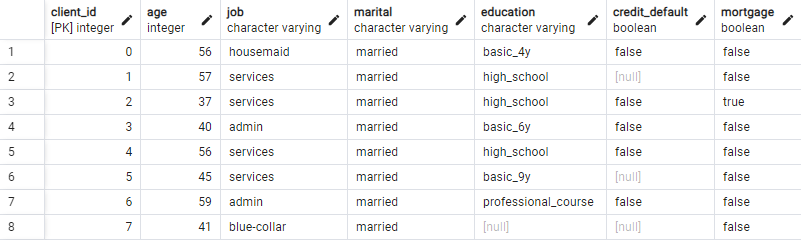

***
### Creating our campaign.csv data

**`campaign.csv` expectations**

| column | data type | description | cleaning requirements |
|--------|-----------|-------------|-----------------------|
| `client_id` | `integer` | Client ID | N/A |
| `number_contacts` | `integer` | Number of contact attempts to the client in the current campaign | N/A |
| `contact_duration` | `integer` | Last contact duration in seconds | N/A |
| `previous_campaign_contacts` | `integer` | Number of contact attempts to the client in the previous campaign | N/A |
| `previous_outcome` | `bool` | Outcome of the previous campaign | Convert to boolean data type |
| `campaign_outcome` | `bool` | Outcome of the current campaign | Convert to boolean data type |
| `last_contact_date` | `datetime` | Last date the client was contacted | Create from a combination of `day`, `month`, and a newly created `year` column (which should have a value of `2022`); <br> **Format =** `"YYYY-MM-DD"` |


Using the `read_csv` function we can use the advanced parameters to get our desired results. 
1. We're only interested in the columns listed above so let's just include them as a list with the `usecols` parameter. 
2. We'll specify what values should be considered as True via the `true_value` parameter.
3. We'll specify what values should be consisderes as False via the `false_value` parameter.

In [16]:
# inspecting what we have for values in the previous_outcome column
print(f'previous_outcome values: {bank_marketing.previous_outcome.unique()}')

# inspecting what we have for values in the campaign_outcome column
print(f'campain_outcome values: {bank_marketing.campaign_outcome.unique()}')

previous_outcome values: ['nonexistent' 'failure' 'success']
campain_outcome values: ['no' 'yes']


Based on the above output I would've asked how the values reported should be handled as it's not completely obvious. For the exerice, no, nonexistent & failure were `False`; yes and success as `True`. nonexistent likely should've been `NULL` as I think this would've indicated that there was no associated previous campaign for the client specified.

In [33]:
# inspecting the month column
print(f'month values: {bank_marketing.month.unique()}')

month values: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']


Our month values are all lower case three leter months so we can use the %b [directive](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) to convert it to an integer. 

In [12]:
from datetime import datetime
campaign = pd.read_csv('data/bank_marketing.csv',
                       usecols=['client_id', 'number_contacts', 'contact_duration', 'previous_campaign_contacts',
                                'previous_outcome', 'campaign_outcome', 'day', 'month'],
                       true_values=['yes', 'success'],
                       false_values=['no', 'failure', 'nonexistent']
                      )                    

# set the year to 2012
campaign['year'] = 2012

# set the month to it's integer equivalent
campaign['month'] = campaign['month'].apply(lambda x: datetime.strptime(x, '%b').month)

# create our new column with a yyyy-mm-dd time format
campaign['last_contact_date'] = pd.to_datetime(campaign[['year', 'month', 'day']])

# drop the columns we no longer need
cols = ['month', 'day', 'year']
campaign.drop(cols, axis=1, inplace=True)

# reorder the cols
campaign = campaign[['client_id', 'number_contacts', 'contact_duration', 'previous_campaign_contacts',
         'previous_outcome', 'campaign_outcome', 'last_contact_date']]
display(campaign.head())
print(campaign.info())

# save our dataframe to csv
campaign.to_csv('cleaned/campaign.csv', index=False)

,client_id,number_contacts,contact_duration,previous_campaign_contacts,previous_outcome,campaign_outcome,last_contact_date
0,0,1,261,0,False,False,2012-05-13
1,1,1,149,0,False,False,2012-05-19
2,2,1,226,0,False,False,2012-05-23
3,3,1,151,0,False,False,2012-05-27
4,4,1,307,0,False,False,2012-05-03


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   client_id                   41188 non-null  int64         
 1   number_contacts             41188 non-null  int64         
 2   contact_duration            41188 non-null  int64         
 3   previous_campaign_contacts  41188 non-null  int64         
 4   previous_outcome            41188 non-null  bool          
 5   campaign_outcome            41188 non-null  bool          
 6   last_contact_date           41188 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](1), int64(4)
memory usage: 1.6 MB
None


***
### Creating our economics.csv data

**`economics.csv`**

| column                 | data type | description                                                              | cleaning requirements |
|------------------------|-----------|--------------------------------------------------------------------------|-----------------------|
| `client_id`            | `integer` | Client ID                                                                | N/A                   |
| `cons_price_idx`       | `float`   | Consumer price index (monthly indicator)                                 | N/A                   |
| `euribor_three_months` | `float`   | Euro Interbank Offered Rate (euribor) three-month rate (daily indicator) | N/A                   |

Using the `read_csv` function we can use the advanced parameters to get our desired results. 
1. We're only interested in the columns listed above so let's just include them as a list with the `usecols` parameter. 
2. All the columns contain numeric values so no special handling is required. 


In [13]:
economics = pd.read_csv('data/bank_marketing.csv',
                        usecols=['client_id', 'cons_price_idx', 'euribor_three_months'],
                        )

display(economics.head())
print(economics.info())

# save our dataframe to csv
economics.to_csv('cleaned/economics.csv', index=False)

,client_id,cons_price_idx,euribor_three_months
0,0,93.994,4.857
1,1,93.994,4.857
2,2,93.994,4.857
3,3,93.994,4.857
4,4,93.994,4.857


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             41188 non-null  int64  
 1   cons_price_idx        41188 non-null  float64
 2   euribor_three_months  41188 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 965.5 KB
None


***
### Summary
- All files are stored in the cleaned folder. 
- All three files contain 41188 records. 
- All three files contain the header information. 
  - This will need to be taken into account when importing the data to PostgreSQL. 
- Missing values for `mortgage`, `credit_default` and `education` were left empty


### Complete Conversion Code

In [34]:
# all conversion code in one cell
import pandas as pd
from datetime import datetime

# client conversion
client = pd.read_csv('data/bank_marketing.csv',
                     usecols=['client_id', 'age', 'job', 'marital', 'education', 'credit_default', 'mortgage'],
                     true_values=['yes'],
                     false_values=['no'],
                     na_values=['unknown']
                    )

#apply string replacements
client['education'] = client['education'].str.replace('.', '_')

# This original requirement specified replacing the period with an underscore. 
# The values contained only have admin. which is an abbreveation and would look weird with an underscore. 
# Removing the period makes more sense.
client['job'] = client['job'].str.replace('.', '') 

# save our dataframe to csv
client.to_csv('cleaned/client.csv', index=False)

# campaign conversion
campaign = pd.read_csv('data/bank_marketing.csv',
                       usecols=['client_id', 'number_contacts', 'contact_duration', 'previous_campaign_contacts',
                                'previous_outcome', 'campaign_outcome', 'day', 'month'],
                       true_values=['yes', 'success'],
                       false_values=['no', 'failure', 'nonexistent']
                      )                    

# set the year to 2012
campaign['year'] = 2012

# set the month to it's integer equivalent
campaign['month'] = campaign['month'].apply(lambda x: datetime.strptime(x, '%b').month)

# create our new column with a yyyy-mm-dd time format
campaign['last_contact_date'] = pd.to_datetime(campaign[['year', 'month', 'day']])

# drop the columns we no longer need
cols = ['month', 'day', 'year']
campaign.drop(cols, axis=1, inplace=True)

# reorder the cols
campaign = campaign[['client_id', 'number_contacts', 'contact_duration', 'previous_campaign_contacts',
         'previous_outcome', 'campaign_outcome', 'last_contact_date']]

# save our dataframe to csv
campaign.to_csv('cleaned/campaign.csv', index=False)

# economics conversion
economics = pd.read_csv('data/bank_marketing.csv',
                        usecols=['client_id', 'cons_price_idx', 'euribor_three_months'],
                        )

# save our dataframe to csv
economics.to_csv('cleaned/economics.csv', index=False)